In [2]:
%load_ext autoreload
%autoreload 2

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import json
from random import sample

import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn.functional as F

from transformers import *

import collections
import os

import nltk
%matplotlib inline

from pandas import Series,DataFrame
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# 先处理 DiffVec的数据
filename = 'diffvec_word_pairs_final.SEMBLESS.csv'
file_colname=['relation','word1','word2']
df = pd.read_csv(filename,header=None,names=file_colname)

df

,relation,word1,word2
0,ATTRIBUTE$Action:ObjectAttribute,apple,picker
1,ATTRIBUTE$Action:ObjectAttribute,collect,fee
2,ATTRIBUTE$Action:ObjectAttribute,hunter,game
3,ATTRIBUTE$Action:ObjectAttribute,paint,house
4,ATTRIBUTE$Action:ObjectAttribute,vitamin,deficiency
...,...,...,...
12453,vn-deriv,yawn,yawning
12454,vn-deriv,yearn,yearning
12455,vn-deriv,yell,yelling
12456,vn-deriv,yield,yielding


In [35]:
df_clean = df[df['relation'].str.contains('Prevention')]
df_clean

,relation,word1,word2
287,CAUSE-PURPOSE$Prevention,acetaminophen,headache
288,CAUSE-PURPOSE$Prevention,acid,base
289,CAUSE-PURPOSE$Prevention,activity,boredom
290,CAUSE-PURPOSE$Prevention,antibiotic,infection
291,CAUSE-PURPOSE$Prevention,antibiotics,bacteria
292,CAUSE-PURPOSE$Prevention,cat,mouse
293,CAUSE-PURPOSE$Prevention,cure,disease
294,CAUSE-PURPOSE$Prevention,education,ignorance
295,CAUSE-PURPOSE$Prevention,fast,slow
296,CAUSE-PURPOSE$Prevention,food,hunger


In [153]:
# 先处理相同 word1 的数据，合并，再转换成列表
data = df_clean.groupby(['word1'])['word2'].apply(list).to_dict()
print(data)


# 提取形容词
adj_data_dict = {}
not_adj = {}

for (key,value) in data.items():
    if nltk.pos_tag([key])[0][1] == "JJ":
        adj_data_dict[key] = value
    else:
        not_adj[key] = nltk.pos_tag([key])[0][1]
        
print(adj_data_dict)
print('============================================')
print(not_adj)

# 最终的数据是 adj_data_dict


{'acetaminophen': ['headache'], 'acid': ['base'], 'activity': ['boredom'], 'antibiotic': ['infection'], 'antibiotics': ['bacteria'], 'cat': ['mouse'], 'cure': ['disease'], 'education': ['ignorance'], 'fast': ['slow'], 'food': ['hunger'], 'fungicide': ['fungus', 'mold'], 'good': ['bad'], 'happy': ['sad'], 'immunization': ['disease'], 'insecticide': ['bugs', 'pests'], 'knowledge': ['ignorance'], 'locks': ['theft'], 'mediation': ['conflict'], 'medicine': ['disease', 'illness'], 'money': ['poverty'], 'nice': ['evil'], 'preparation': ['disaster'], 'rest': ['exhaustion'], 'shot': ['disease'], 'sleep': ['exhaustion', 'tiredness'], 'sun': ['darkness'], 'swimming': ['drowning'], 'vaccine': ['virus'], 'water': ['thirst']}
{'antibiotic': ['infection'], 'good': ['bad'], 'happy': ['sad'], 'nice': ['evil']}
{'acetaminophen': 'NN', 'acid': 'NN', 'activity': 'NN', 'antibiotics': 'NNS', 'cat': 'NN', 'cure': 'NN', 'education': 'NN', 'fast': 'NN', 'food': 'NN', 'fungicide': 'NN', 'immunization': 'NN', 'i

In [40]:
# 再处理 BAT3的数据

In [43]:
bat3file1 = open('antonyms_adj.txt')
bat3file2 = open('antonyms_comparable.txt')


antonyms_adj = bat3file1.read()
antonyms_comparable = bat3file2.read()

print(antonyms_adj)
print(antonyms_comparable)

beautiful/pretty	ugly/disfigured/evil-looking/fugly/grotesque/monstrous/hideous/repulsive/ill-favored/ill-favoured/scrofulous/unlovely/unpicturesque/unsightly/displeasing/unattractive/awkward
big	small/atomic/subatomic/bantam/diminutive/lilliputian/midget/petite/tiny/flyspeck/bitty/bittie/teensy/teentsy/teeny/wee/weeny/weensy/teensy-weensy/teeny-weeny/itty-bitty/itsy-bitsy/dinky/dwarfish/elfin/elflike/gnomish/half-size/infinitesimal/minute/lesser/microscopic/microscopical/micro/miniature/minuscule/miniscule/olive-sized/pocket-size/pocket-sized/pocketable/puny/runty/shrimpy/slender/slim/smaller/littler/smallish/small-scale/undersize/undersized
bright	pale/colorless/colourless/dull/neutral/pale/white/bleached/faded/washed-out/washy/drab/somber/sombre/dulled/greyed/etiolate/etiolated/lurid/waxen/waxlike/waxy/whitened
cheap	expensive/big-ticket/high-ticket/costly/dear/high-priced/pricey/pricy/dearly-won/overpriced/valuable
clean	dirty/soiled/unclean/augean/bedraggled/draggled/befouled/foul

In [69]:
antonyms_dict = {}
files = [bat3file1,bat3file2]

for each in files:
    
    # put the pos to the start of file
    each.seek(0, os.SEEK_SET)

    for line in each.read().split("\n"):
        # 处理 空行
        if not line:
            continue
        line_split = line.split()
        master = line_split[0]
        slave = line_split[1].split('/')
        
        # 处理多个 master
        if '/' in master:
            master_list = master.split('/')
            for each_master in master_list:
                if not each_master in antonyms_dict:
                    antonyms_dict[each_master] = slave
        else:
            if not master in antonyms_dict:
                antonyms_dict[master] = slave
            
ordered_antonyms_dict = collections.OrderedDict(sorted(antonyms_dict.items()))
ordered_antonyms_dict

#print(type(ordered_antonyms_dict))

# 最终的数据是 ordered_antonyms_dict

OrderedDict([('able', ['unable', 'incapable', 'incompetent', 'unequal']),
             ('abundant',
              ['scarce',
               'rare',
               'tight',
               'meager',
               'meagre',
               'meagerly',
               'stingy',
               'scrimpy',
               'insufficient',
               'deficient']),
             ('aware',
              ['unaware',
               'oblivious',
               'unmindful',
               'unconscious',
               'unsuspecting',
               'asleep',
               'insensible',
               'unconscious',
               'unwitting',
               'ignorant',
               'indifferent',
               'oblivious']),
             ('beautiful',
              ['ugly',
               'disfigured',
               'evil-looking',
               'fugly',
               'grotesque',
               'monstrous',
               'hideous',
               'repulsive',
               'ill-favored',


In [54]:
# 全是形容词，不需要使用nltk选出形容词
# 但是有的 master 是有两个的需要处理一下

In [62]:
models = {}

model_class, tokenizer_class, shortcut, mask_token = RobertaForMaskedLM, RobertaTokenizer, 'roberta-base', '<mask>'
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

model_class, tokenizer_class, shortcut, mask_token = RobertaForMaskedLM, RobertaTokenizer, 'roberta-large', '<mask>'
model, tokenizer = model_class.from_pretrained(shortcut), tokenizer_class.from_pretrained(shortcut)
models[shortcut] = (model, tokenizer, mask_token)

model, tokenizer, mask_token = models['roberta-large']

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-large and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
templates = [
    'John is * but Mary is  _ .'
]

In [64]:
# 处理 am-for-bert 数据

In [151]:
import re
am_for_bert = 'am_for_bert_antonyms.txt'
#am_for_bert_file = open(am_for_bert)

with open(am_for_bert, 'r') as f:
    file_lines = f.readlines()

keymap =  [re.split(' |\t',string) for string in file_lines]

adj_antonym = {}
flag = 0
for item in keymap:

    # 筛选出形态词的反义词
    if (('antonym' == item[4]) and ('a' in item[3])):
        master3 = item[2]
        slave3 = []
        length = len(item)
        
        for i in range(int((length-5)/2)):
            slave3.append(item[5+i*2])
        
        adj_antonym[master3] = slave3
        
print(adj_antonym)
print(len(adj_antonym))

# 最终的数据 adj_antonym


{'new': ['old'], 'other': ['same'], 'many': ['few'], 'high': ['low'], 'same': ['other'], 'general': ['specific'], 'international': ['national'], 'local': ['national'], 'small': ['big', 'large'], 'large': ['little', 'small'], 'much': ['little'], 'old': ['young'], 'single': ['common'], 'different': ['same'], 'white': ['black'], 'few': ['many'], 'popular': ['unpopular'], 'black': ['white'], 'young': ['old'], 'northern': ['southern'], 'married': ['unmarried'], 'southern': ['northern'], 'little': ['big', 'large'], 'good': ['bad'], 'available': ['unavailable'], 'full': ['empty'], 'able': ['unable'], 'successful': ['unsuccessful'], 'native': ['foreign'], 'possible': ['impossible'], 'natural': ['unnatural'], 'big': ['little', 'small'], 'strong': ['weak'], 'active': ['inactive'], 'limited': ['unlimited'], 'low': ['high'], 'foreign': ['domestic'], 'related': ['unrelated'], 'legal': ['illegal'], 'true': ['false'], 'dead': ['alive'], 'specific': ['general'], 'hard': ['easy'], 'likely': ['unlikely'

In [157]:
print(adj_data_dict)
print('===========================')
print(ordered_antonyms_dict)
print('===========================')
print(adj_antonym)


{'antibiotic': ['infection'], 'good': ['bad'], 'happy': ['sad'], 'nice': ['evil']}
OrderedDict([('able', ['unable', 'incapable', 'incompetent', 'unequal']), ('abundant', ['scarce', 'rare', 'tight', 'meager', 'meagre', 'meagerly', 'stingy', 'scrimpy', 'insufficient', 'deficient']), ('aware', ['unaware', 'oblivious', 'unmindful', 'unconscious', 'unsuspecting', 'asleep', 'insensible', 'unconscious', 'unwitting', 'ignorant', 'indifferent', 'oblivious']), ('beautiful', ['ugly', 'disfigured', 'evil-looking', 'fugly', 'grotesque', 'monstrous', 'hideous', 'repulsive', 'ill-favored', 'ill-favoured', 'scrofulous', 'unlovely', 'unpicturesque', 'unsightly', 'displeasing', 'unattractive', 'awkward']), ('big', ['small', 'atomic', 'subatomic', 'bantam', 'diminutive', 'lilliputian', 'midget', 'petite', 'tiny', 'flyspeck', 'bitty', 'bittie', 'teensy', 'teentsy', 'teeny', 'wee', 'weeny', 'weensy', 'teensy-weensy', 'teeny-weeny', 'itty-bitty', 'itsy-bitsy', 'dinky', 'dwarfish', 'elfin', 'elflike', 'gnomi

In [158]:
final_antonym_dict = {}
final_antonym_dict.update(adj_data_dict)
final_antonym_dict.update(ordered_antonyms_dict)
final_antonym_dict.update(adj_antonym)

In [167]:
# 合并后的数据
print(final_antonym_dict)
print('===========')

# 复制一份作为 最后结果的json 文件的生成文件
import copy

result_dict = copy.deepcopy(final_antonym_dict)
result_dict

import json

{'antibiotic': ['infection'], 'good': ['bad'], 'happy': ['unhappy'], 'nice': ['nasty'], 'able': ['unable'], 'abundant': ['scarce', 'rare', 'tight', 'meager', 'meagre', 'meagerly', 'stingy', 'scrimpy', 'insufficient', 'deficient'], 'aware': ['unaware', 'oblivious', 'unmindful', 'unconscious', 'unsuspecting', 'asleep', 'insensible', 'unconscious', 'unwitting', 'ignorant', 'indifferent', 'oblivious'], 'beautiful': ['ugly', 'disfigured', 'evil-looking', 'fugly', 'grotesque', 'monstrous', 'hideous', 'repulsive', 'ill-favored', 'ill-favoured', 'scrofulous', 'unlovely', 'unpicturesque', 'unsightly', 'displeasing', 'unattractive', 'awkward'], 'big': ['little', 'small'], 'bright': ['pale', 'colorless', 'colourless', 'dull', 'neutral', 'pale', 'white', 'bleached', 'faded', 'washed-out', 'washy', 'drab', 'somber', 'sombre', 'dulled', 'greyed', 'etiolate', 'etiolated', 'lurid', 'waxen', 'waxlike', 'waxy', 'whitened'], 'cheap': ['expensive', 'big-ticket', 'high-ticket', 'costly', 'dear', 'high-pric

In [161]:
templates = [
    'John is * but Mary is _ .',
    'The antonym of * is _ .'
]

John is antibiotic but Mary is _ .
['not', 'Catholic', 'Jewish', 'pregnant', 'alive', 'gay', 'Christian', 'dead', 'Baptist', 'Muslim']
tensor([0.2017, 0.0369, 0.0303, 0.0162, 0.0140, 0.0109, 0.0100, 0.0094, 0.0087,
        0.0072])
{'infection': tensor(8.2644e-07)}
max_probe is: tensor(8.2644e-07)
20
40
80
160
320
640
1280
2560
5120
10240
20480
the position of max probe is: 12846
-----------------------------------------------------
*****************************************************
The antonym of antibiotic is _ .
['antibiotic', 'and', ',', 'or', 'also', 'in', 'the', ':', 'antibiotics', '']
tensor([0.1225, 0.1042, 0.0408, 0.0391, 0.0315, 0.0255, 0.0176, 0.0151, 0.0140,
        0.0129])
{'infection': tensor(0.0002)}
max_probe is: tensor(0.0002)
20
40
80
160
320
640
the position of max probe is: 484
-----------------------------------------------------
*****************************************************
John is good but Mary is _ .
['better', 'bad', 'good', 'great', 'beautiful', 'e

['beautiful', 'elegant', 'handsome', 'perfect', 'attractive', 'gorgeous', 'pretty', 'brilliant', 'admirable', 'charming']
tensor([0.3959, 0.0218, 0.0151, 0.0135, 0.0121, 0.0114, 0.0097, 0.0086, 0.0086,
        0.0080])
disfiguredis not in list
evil-lookingis not in list
fuglyis not in list
repulsiveis not in list
ill-favoredis not in list
ill-favouredis not in list
scrofulousis not in list
unlovelyis not in list
unpicturesqueis not in list
unsightlyis not in list
displeasingis not in list
unattractiveis not in list
{'ugly': tensor(0.0018), 'grotesque': tensor(0.0002), 'monstrous': tensor(6.0596e-05), 'hideous': tensor(8.3143e-05), 'awkward': tensor(0.0001)}
max_probe is: tensor(0.0018)
20
40
80
the position of max probe is: 66
-----------------------------------------------------
*****************************************************
John is big but Mary is _ .
['small', 'tiny', 'beautiful', 'strong', 'little', 'smaller', 'pretty', 'big', 'bigger', 'tall']
tensor([0.2324, 0.0911, 0.0633

['not', 'stronger', 'closer', 'ahead', 'better', 'far', 'free', 'gone', 'alone', 'different']
tensor([0.0623, 0.0469, 0.0453, 0.0271, 0.0267, 0.0206, 0.0146, 0.0133, 0.0130,
        0.0120])
farawayis not in list
{'distant': tensor(0.0074), 'remote': tensor(0.0004), 'removed': tensor(0.0002), 'far': tensor(0.0206), '': tensor(8.0063e-05)}
max_probe is: tensor(0.0206)
the position of max probe is: 5
-----------------------------------------------------
*****************************************************
The antonym of close is _ .
['close', 'closed', 'open', 'also', ',', 'near', 'tight', 'short', 'called', '.']
tensor([0.2839, 0.0694, 0.0415, 0.0367, 0.0290, 0.0160, 0.0149, 0.0139, 0.0129,
        0.0125])
farawayis not in list
{'distant': tensor(0.0016), 'remote': tensor(0.0005), 'removed': tensor(3.3104e-05), 'far': tensor(0.0029), '': tensor(5.0398e-05)}
max_probe is: tensor(0.0029)
20
40
the position of max probe is: 29
-----------------------------------------------------
*******

['not', 'beautiful', 'stronger', 'innocent', 'strong', 'free', 'better', 'safe', 'powerful', 'trustworthy']
tensor([0.0995, 0.0699, 0.0313, 0.0307, 0.0230, 0.0199, 0.0192, 0.0155, 0.0132,
        0.0130])
{'safe': tensor(0.0155)}
max_probe is: tensor(0.0155)
the position of max probe is: 7
-----------------------------------------------------
*****************************************************
The antonym of dangerous is _ .
['dangerous', 'aggressive', 'risky', 'deadly', 'reckless', 'lethal', 'volatile', 'vigilant', 'hazardous', 'toxic']
tensor([0.1050, 0.0337, 0.0228, 0.0176, 0.0156, 0.0133, 0.0129, 0.0117, 0.0115,
        0.0106])
{'safe': tensor(0.0104)}
max_probe is: tensor(0.0104)
20
the position of max probe is: 10
-----------------------------------------------------
*****************************************************
John is decisive but Mary is _ .
['not', 'decisive', 'vulnerable', 'silent', 'weak', 'powerless', 'conflicted', 'determined', 'involved', 'fragile']
tensor([0.

['empty', 'hungry', 'full', 'starving', 'not', 'lonely', 'thirsty', 'alone', 'ready', 'bursting']
tensor([0.2547, 0.2053, 0.0843, 0.0446, 0.0285, 0.0217, 0.0214, 0.0111, 0.0107,
        0.0089])
{'empty': tensor(0.2547)}
max_probe is: tensor(0.2547)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of full is _ .
['full', 'short', 'empty', ',', 'half', 'complete', 'long', 'also', 'flat', 'double']
tensor([0.2592, 0.0519, 0.0299, 0.0290, 0.0143, 0.0135, 0.0113, 0.0106, 0.0085,
        0.0080])
{'empty': tensor(0.0299)}
max_probe is: tensor(0.0299)
the position of max probe is: 2
-----------------------------------------------------
*****************************************************
John is gaseous but Mary is _ .
['solid', 'liquid', 'not', 'fluid', 'water', 'inert', 'transparent', 'pure', 'immortal', 'dry']
tensor([0.5519, 0.1244, 0.0578, 0.0150, 0.0124, 0.0091, 0.0090, 0.0064, 0.006

['outgoing', 'not', 'shy', 'social', 'outspoken', 'intuitive', 'charismatic', 'passionate', 'optimistic', 'ambitious']
tensor([0.3922, 0.1017, 0.0502, 0.0322, 0.0238, 0.0132, 0.0120, 0.0112, 0.0091,
        0.0081])
extravertis not in list
extrovertis not in list
extrovertedis not in list
sociableis not in list
{'outgoing': tensor(0.3922), 'forthcoming': tensor(0.0013)}
max_probe is: tensor(0.3922)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of introvert is _ .
['shy', 'obsessive', 'pessimistic', 'independent', 'depressive', 'analytic', 'ADD', 'nerd', 'the', 'minimalist']
tensor([0.0692, 0.0421, 0.0331, 0.0209, 0.0169, 0.0165, 0.0158, 0.0139, 0.0121,
        0.0118])
extravertis not in list
extrovertis not in list
extrovertedis not in list
sociableis not in list
{'outgoing': tensor(0.0056), 'forthcoming': tensor(0.0003)}
max_probe is: tensor(0.0056)
20
40
the position of max prob

['not', 'free', 'organized', 'spontaneous', 'spiritual', 'lost', 'chaotic', 'messy', 'passionate', 'born']
tensor([0.2482, 0.0421, 0.0331, 0.0200, 0.0103, 0.0094, 0.0094, 0.0085, 0.0078,
        0.0073])
unorganizedis not in list
unstructuredis not in list
uncoordinatedis not in list
unformedis not in list
unincorporatedis not in list
{}
John is pale but Mary is _ .
['dark', 'not', 'white', 'beautiful', 'black', 'pale', 'darker', 'red', 'fair', 'blonde']
tensor([0.1195, 0.1150, 0.0908, 0.0759, 0.0593, 0.0540, 0.0440, 0.0253, 0.0243,
        0.0181])
tannedis not in list
bronzedis not in list
suntannedis not in list
brunetis not in list
brunetteis not in list
{}
John is pretty but Mary is _ .
['beautiful', 'pretty', 'better', 'smarter', 'special', 'sexy', 'real', 'more', 'lovely', 'amazing']
tensor([0.2285, 0.1289, 0.0347, 0.0189, 0.0165, 0.0161, 0.0161, 0.0159, 0.0126,
        0.0122])
disfiguredis not in list
evil-lookingis not in list
fuglyis not in list
repulsiveis not in list
ill-f

['not', 'better', 'deceptive', 'deceived', 'cunning', 'manipulative', 'desperate', 'evil', 'more', 'selfish']
tensor([0.1343, 0.0277, 0.0244, 0.0226, 0.0177, 0.0164, 0.0143, 0.0127, 0.0125,
        0.0115])
insincereis not in list
bootlickingis not in list
fawningis not in list
obsequiousis not in list
sycophanticis not in list
toadyishis not in list
butteryis not in list
fulsomeis not in list
oleaginousis not in list
smarmyis not in list
soapyis not in list
unctuousis not in list
dissimulativeis not in list
feignedis not in list
gildedis not in list
meretriciousis not in list
speciousis not in list
imitativeis not in list
dishonorableis not in list
disingenuousis not in list
artfulis not in list
{'oily': tensor(2.7864e-06), 'false': tensor(0.0027), 'hypocritical': tensor(0.0014), 'plausible': tensor(3.2485e-05), 'counterfeit': tensor(4.3676e-05), 'dishonest': tensor(0.0097), 'unreal': tensor(8.4008e-05)}
max_probe is: tensor(0.0097)
20
the position of max probe is: 14
----------------

['tight', 'short', 'flexible', 'narrow', ',', 'loose', 'tense', 'strict', 'relaxed', 'compact']
tensor([0.3337, 0.0359, 0.0238, 0.0174, 0.0141, 0.0140, 0.0139, 0.0120, 0.0115,
        0.0107])
baggyis not in list
loose-fittingis not in list
flyawayis not in list
{'loose': tensor(0.0140), 'lax': tensor(0.0064), 'sloppy': tensor(0.0002), 'free': tensor(0.0009), 'liberal': tensor(6.2991e-05), 'informal': tensor(0.0003), 'unofficial': tensor(1.1034e-05)}
max_probe is: tensor(0.0140)
the position of max probe is: 5
-----------------------------------------------------
*****************************************************
John is warm but Mary is _ .
['cold', 'not', 'freezing', 'frozen', 'warm', 'chilly', 'colder', 'hot', 'hungry', 'afraid']
tensor([0.7989, 0.0324, 0.0157, 0.0117, 0.0103, 0.0103, 0.0072, 0.0066, 0.0065,
        0.0045])
frostyis not in list
frigidis not in list
{'cool': tensor(0.0040), 'cold': tensor(0.7989), 'chilly': tensor(0.0103)}
max_probe is: tensor(0.7989)
the positio

['high', 'low', ',', 'long', 'and', 'also', 'High', 'short', 'or', 'called']
tensor([0.6364, 0.1579, 0.0305, 0.0113, 0.0060, 0.0056, 0.0054, 0.0053, 0.0030,
        0.0029])
{'low': tensor(0.1579)}
max_probe is: tensor(0.1579)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is same but Mary is _ .
['different', 'not', 'Mary', 'other', 'new', 'special', 'better', 'female', 'more', 'same']
tensor([0.7322, 0.0193, 0.0109, 0.0082, 0.0079, 0.0070, 0.0061, 0.0043, 0.0039,
        0.0038])
{'other': tensor(0.0082)}
max_probe is: tensor(0.0082)
the position of max probe is: 3
-----------------------------------------------------
*****************************************************
The antonym of same is _ .
[',', 'and', 'also', 'written', 'called', '', 'the', ':', 'then', '']
tensor([0.1581, 0.0862, 0.0847, 0.0444, 0.0407, 0.0362, 0.0259, 0.0240, 0.0169,
        0.0166])
{'other': tensor(5.7075e-0

['different', 'and', ',', 'also', 'similar', 'distinct', 'identical', 'the', 'or', 'called']
tensor([0.3695, 0.0612, 0.0469, 0.0290, 0.0180, 0.0176, 0.0144, 0.0136, 0.0091,
        0.0085])
{'same': tensor(0.0064)}
max_probe is: tensor(0.0064)
20
the position of max probe is: 15
-----------------------------------------------------
*****************************************************
John is few but Mary is _ .
['many', 'everywhere', 'numerous', 'few', 'all', 'one', 'none', 'not', 'more', 'legion']
tensor([0.5157, 0.0449, 0.0439, 0.0274, 0.0251, 0.0238, 0.0177, 0.0157, 0.0153,
        0.0081])
{'many': tensor(0.5157)}
max_probe is: tensor(0.5157)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of few is _ .
['also', ',', 'many', 'and', 'small', '.', 'only', '1', 'few', 'the']
tensor([0.0460, 0.0437, 0.0430, 0.0395, 0.0253, 0.0201, 0.0183, 0.0183, 0.0166,
        0.0149])
{'many': te

['not', 'American', 'English', 'white', 'adopted', 'Irish', 'British', 'Scottish', 'Catholic', 'German']
tensor([0.2169, 0.1116, 0.0762, 0.0512, 0.0505, 0.0359, 0.0314, 0.0267, 0.0227,
        0.0226])
{'foreign': tensor(0.0022)}
max_probe is: tensor(0.0022)
20
40
the position of max probe is: 38
-----------------------------------------------------
*****************************************************
The antonym of native is _ .
['native', ',', 'indigenous', 'natural', 'also', 'wild', 'local', 'cultivated', 'common', 'the']
tensor([0.5919, 0.0366, 0.0214, 0.0181, 0.0093, 0.0093, 0.0070, 0.0068, 0.0068,
        0.0054])
{'foreign': tensor(0.0005)}
max_probe is: tensor(0.0005)
20
40
80
160
the position of max probe is: 116
-----------------------------------------------------
*****************************************************
John is possible but Mary is _ .
['not', 'unlikely', 'impossible', 'doubtful', 'likely', 'probable', 'possible', 'no', 'certain', 'difficult']
tensor([0.5282, 

['called', ',', 'and', 'the', 'also', 'related', 'named', 'or', 'of', '.']
tensor([0.1612, 0.1197, 0.0774, 0.0541, 0.0346, 0.0315, 0.0288, 0.0189, 0.0161,
        0.0157])
{'unrelated': tensor(0.0017)}
max_probe is: tensor(0.0017)
20
40
80
the position of max probe is: 56
-----------------------------------------------------
*****************************************************
John is legal but Mary is _ .
['not', 'illegal', 'legal', 'illegitimate', 'dead', 'immoral', 't', 'alive', 'Catholic', 'Jewish']
tensor([0.6468, 0.0965, 0.0184, 0.0166, 0.0152, 0.0103, 0.0082, 0.0040, 0.0034,
        0.0032])
{'illegal': tensor(0.0965)}
max_probe is: tensor(0.0965)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
The antonym of legal is _ .
['legal', 'valid', 'mandatory', 'constitutional', 'criminal', 'medical', 'civil', 'statutory', 'practical', 'just']
tensor([0.0810, 0.0218, 0.0168, 0.0161, 0.0159, 0.01

['necessary', 'required', 'needed', 'also', 'and', 'sufficient', 'always', ',', 'need', 'obligatory']
tensor([0.2568, 0.0630, 0.0582, 0.0450, 0.0308, 0.0268, 0.0214, 0.0168, 0.0141,
        0.0101])
{'unnecessary': tensor(0.0068)}
max_probe is: tensor(0.0068)
20
the position of max probe is: 14
-----------------------------------------------------
*****************************************************
John is nuclear but Mary is _ .
['radioactive', 'nuclear', 'not', 'human', 'organic', 'warm', 'atomic', 'magical', 'cold', 'green']
tensor([0.0880, 0.0681, 0.0414, 0.0334, 0.0165, 0.0159, 0.0135, 0.0102, 0.0099,
        0.0098])
{'conventional': tensor(0.0054)}
max_probe is: tensor(0.0054)
20
the position of max probe is: 17
-----------------------------------------------------
*****************************************************
The antonym of nuclear is _ .
['electron', 'gamma', 'nuclear', 'atomic', 'and', ',', 'electric', 'radioactive', 'electromagnetic', 'positive']
tensor([0.1650, 0.

['formal', 'informal', 'nominal', 'formally', 'procedural', ',', 'explicit', 'functional', 'simple', 'verbal']
tensor([0.6377, 0.1778, 0.0091, 0.0087, 0.0048, 0.0036, 0.0027, 0.0026, 0.0023,
        0.0023])
{'informal': tensor(0.1778)}
max_probe is: tensor(0.1778)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is external but Mary is _ .
['internal', 'interior', 'inner', 'external', 'spiritual', 'inside', 'inward', 'within', 'Internal', 'not']
tensor([0.8665, 0.0158, 0.0102, 0.0086, 0.0072, 0.0055, 0.0046, 0.0038, 0.0038,
        0.0034])
{'internal': tensor(0.8665)}
max_probe is: tensor(0.8665)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of external is _ .
['external', 'internal', ',', 'and', 'External', 'also', 'externally', 'internally', 'physical', 'positive']
tensor([0.6081, 0.

['instrumental', 'vocal', ',', 'piano', 'musical', 'and', 'the', 'also', 'pronounced', 'bass']
tensor([0.1061, 0.1041, 0.0520, 0.0291, 0.0206, 0.0176, 0.0152, 0.0151, 0.0109,
        0.0091])
{'vocal': tensor(0.1041)}
max_probe is: tensor(0.1041)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is illegal but Mary is _ .
['not', 'legal', 'free', 'illegal', 'innocent', 'exempt', 'holy', 'Catholic', '', 'safe']
tensor([0.5467, 0.1129, 0.0318, 0.0120, 0.0118, 0.0091, 0.0065, 0.0054, 0.0050,
        0.0049])
{'legal': tensor(0.1129)}
max_probe is: tensor(0.1129)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
The antonym of illegal is _ .
['illegal', 'legal', 'lawful', 'unlawful', 'criminal', 'illicit', 'forbidden', 'prohibited', 'obscene', 'unethical']
tensor([0.3331, 0.1147, 0.0328, 0.0306, 0.0258, 0.01

['not', 'unstable', 'pregnant', 'troubled', 'volatile', 'unpredictable', 'restless', 'unhappy', 'struggling', 'dangerous']
tensor([0.3624, 0.1557, 0.0262, 0.0191, 0.0118, 0.0106, 0.0093, 0.0089, 0.0064,
        0.0058])
{'unstable': tensor(0.1557)}
max_probe is: tensor(0.1557)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
The antonym of stable is _ .
['stable', 'unstable', ',', 'steady', 'stabilized', 'and', 'solid', 'constant', 'also', 'fixed']
tensor([0.6398, 0.0344, 0.0202, 0.0148, 0.0135, 0.0131, 0.0125, 0.0107, 0.0102,
        0.0100])
{'unstable': tensor(0.0344)}
max_probe is: tensor(0.0344)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is usual but Mary is _ .
['not', 'unusual', 'rare', 'special', 'different', 'unique', 'uncommon', 'new', 'a', '']
tensor([0.1347, 0.1197, 0.0698, 0.0650, 0.

['real', 'not', 'human', 'divine', 'natural', 'organic', 'alive', 'genuine', 'true', 'immortal']
tensor([0.6838, 0.1134, 0.0408, 0.0146, 0.0094, 0.0063, 0.0055, 0.0048, 0.0046,
        0.0042])
{'natural': tensor(0.0094)}
max_probe is: tensor(0.0094)
the position of max probe is: 4
-----------------------------------------------------
*****************************************************
The antonym of artificial is _ .
['artificial', 'natural', 'synthetic', ',', 'and', 'also', 'real', 'the', 'exact', 'chemical']
tensor([0.2521, 0.1158, 0.0659, 0.0341, 0.0282, 0.0184, 0.0110, 0.0073, 0.0071,
        0.0067])
{'natural': tensor(0.1158)}
max_probe is: tensor(0.1158)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is empty but Mary is _ .
['full', 'not', 'filled', 'alive', 'whole', 'filling', 'pregnant', 'empty', 'overflowing', 'beautiful']
tensor([0.4559, 0.0691, 0.0678, 0.0312, 0.0216, 0.019

['reliable', 'unreliable', 'trustworthy', 'accurate', 'reliability', ',', 'secure', 'also', 'safe', 'stable']
tensor([0.6047, 0.0307, 0.0252, 0.0188, 0.0075, 0.0071, 0.0070, 0.0068, 0.0059,
        0.0056])
{'unreliable': tensor(0.0307)}
max_probe is: tensor(0.0307)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is sudden but Mary is _ .
['not', 'ready', 'patient', 'late', 'waiting', 'silent', 'prepared', 'strong', 'quiet', 'pregnant']
tensor([0.2132, 0.0356, 0.0256, 0.0214, 0.0197, 0.0120, 0.0119, 0.0105, 0.0101,
        0.0083])
{'gradual': tensor(0.0003)}
max_probe is: tensor(0.0003)
20
40
80
160
320
640
the position of max probe is: 446
-----------------------------------------------------
*****************************************************
The antonym of sudden is _ .
['also', ',', 'and', 'pronounced', '.', 'the', 'or', '', ':', 'always']
tensor([0.0936, 0.0841, 0.0732, 0.0327, 0.02

['not', 'scared', 'afraid', 'worried', 'uncomfortable', 'terrified', 'frightened', 'nervous', 'restless', 'lonely']
tensor([0.3201, 0.0475, 0.0470, 0.0378, 0.0312, 0.0270, 0.0178, 0.0143, 0.0125,
        0.0117])
{'uncomfortable': tensor(0.0312)}
max_probe is: tensor(0.0312)
the position of max probe is: 4
-----------------------------------------------------
*****************************************************
The antonym of comfortable is _ .
['comfortable', 'relaxed', 'convenient', 'calm', 'flexible', 'easy', 'pleasant', 'safe', 'confident', 'cool']
tensor([0.2359, 0.0881, 0.0187, 0.0176, 0.0163, 0.0158, 0.0156, 0.0151, 0.0122,
        0.0117])
{'uncomfortable': tensor(0.0102)}
max_probe is: tensor(0.0102)
20
the position of max probe is: 12
-----------------------------------------------------
*****************************************************
John is uncommon but Mary is _ .
['rare', 'common', 'not', 'uncommon', 'ubiquitous', 'abundant', 'unusual', '', 'unique', 'scarce']
tens

['induced', 'and', ',', 'also', 'written', 'in', 'of', 'called', 'or', 'the']
tensor([0.2749, 0.0529, 0.0349, 0.0306, 0.0132, 0.0095, 0.0082, 0.0077, 0.0076,
        0.0076])
{'spontaneous': tensor(0.0002)}
max_probe is: tensor(0.0002)
20
40
80
160
320
640
the position of max probe is: 438
-----------------------------------------------------
*****************************************************
John is unlimited but Mary is _ .
['not', 'finite', 'limited', 'immortal', 'unlimited', 'restricted', 'infinite', 'mortal', 'eternal', 'free']
tensor([0.4148, 0.1000, 0.0951, 0.0226, 0.0225, 0.0135, 0.0132, 0.0071, 0.0057,
        0.0044])
{'limited': tensor(0.0951)}
max_probe is: tensor(0.0951)
the position of max probe is: 2
-----------------------------------------------------
*****************************************************
The antonym of unlimited is _ .
['unlimited', 'infinite', 'finite', 'indefinite', 'Unlimited', 'limitless', 'limited', 'free', 'and', 'also']
tensor([0.3561, 0.1018

['spiritual', 'not', 'metaphysical', 'symbolic', 'mystical', 'subjective', 'intuitive', 'religious', 'divine', 'theological']
tensor([0.1967, 0.0582, 0.0505, 0.0338, 0.0282, 0.0256, 0.0229, 0.0218, 0.0209,
        0.0205])
{'theoretical': tensor(0.0068)}
max_probe is: tensor(0.0068)
20
40
the position of max probe is: 26
-----------------------------------------------------
*****************************************************
The antonym of empirical is _ .
['empirical', 'statistical', 'quantitative', 'experimental', 'theoretical', 'approximate', 'systematic', 'observational', 'scientific', 'exact']
tensor([0.3406, 0.0388, 0.0358, 0.0338, 0.0148, 0.0124, 0.0124, 0.0115, 0.0105,
        0.0098])
{'theoretical': tensor(0.0148)}
max_probe is: tensor(0.0148)
the position of max probe is: 4
-----------------------------------------------------
*****************************************************
John is peripheral but Mary is _ .
['central', 'pivotal', 'important', 'integral', 'primary', 

['constitutional', 'unconstitutional', 'illegal', 'Constitutional', 'null', 'statutory', 'unlawful', 'just', 'void', 'equal']
tensor([0.1778, 0.1051, 0.1044, 0.0379, 0.0289, 0.0199, 0.0137, 0.0123, 0.0118,
        0.0117])
{'constitutional': tensor(0.1778)}
max_probe is: tensor(0.1778)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is abnormal but Mary is _ .
['normal', 'not', 'perfect', 'beautiful', 'special', 'ordinary', 'healthy', 'extraordinary', 'abnormal', 'unique']
tensor([0.4020, 0.1354, 0.0817, 0.0320, 0.0173, 0.0157, 0.0144, 0.0136, 0.0124,
        0.0109])
{'normal': tensor(0.4020)}
max_probe is: tensor(0.4020)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of abnormal is _ .
['abnormal', 'normal', 'pathological', 'unusual', 'extreme', 'rare', 'exceptional', 'bizarre', 'irreg

['not', 'unreliable', 'credible', 'dangerous', '', 'deceptive', 'delusional', 'more', 'lying', 'too']
tensor([0.5301, 0.0332, 0.0133, 0.0117, 0.0110, 0.0103, 0.0103, 0.0086, 0.0066,
        0.0066])
{'incredible': tensor(0.0005)}
max_probe is: tensor(0.0005)
20
40
80
160
the position of max probe is: 138
-----------------------------------------------------
*****************************************************
The antonym of credible is _ .
['reliable', 'trustworthy', 'credible', 'unreliable', 'accurate', 'true', 'verified', 'truthful', 'proven', 'false']
tensor([0.2028, 0.0528, 0.0466, 0.0323, 0.0157, 0.0138, 0.0133, 0.0109, 0.0105,
        0.0099])
{'incredible': tensor(0.0002)}
max_probe is: tensor(0.0002)
20
40
80
160
320
640
the position of max probe is: 586
-----------------------------------------------------
*****************************************************
John is lawful but Mary is _ .
['not', 'immoral', 'illegitimate', 'evil', 'unlawful', 'lawful', 'illegal', 'sinful', '

['kind', 'beautiful', 'sweet', 'lovely', 'nice', 'nicer', 'pretty', 'good', 'wonderful', 'better']
tensor([0.0809, 0.0715, 0.0508, 0.0495, 0.0467, 0.0385, 0.0337, 0.0240, 0.0181,
        0.0173])
{'nice': tensor(0.0467)}
max_probe is: tensor(0.0467)
the position of max probe is: 4
-----------------------------------------------------
*****************************************************
The antonym of nasty is _ .
['nasty', 'sour', 'mean', 'naughty', 'annoying', 'disgusting', 'unpleasant', 'bad', 'evil', 'good']
tensor([0.0638, 0.0359, 0.0311, 0.0226, 0.0193, 0.0189, 0.0186, 0.0168, 0.0147,
        0.0147])
{'nice': tensor(0.0142)}
max_probe is: tensor(0.0142)
20
the position of max probe is: 12
-----------------------------------------------------
*****************************************************
John is inaccessible but Mary is _ .
['not', 'accessible', 'available', 'free', 'indispensable', 'there', '', 'everywhere', 'safe', 'powerful']
tensor([0.2194, 0.1021, 0.0680, 0.0233, 0.0

['irrational', 'rational', 'exponential', 'absurd', 'logical', 'and', 'arbitrary', 'arithmetic', 'normal', ',']
tensor([0.4120, 0.2364, 0.0165, 0.0100, 0.0094, 0.0078, 0.0060, 0.0053, 0.0050,
        0.0049])
{'rational': tensor(0.2364)}
max_probe is: tensor(0.2364)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is sensible but Mary is _ .
['not', 'stupid', 'crazy', 'naive', 'beautiful', 'naÃ¯ve', 'stubborn', 'foolish', 'insane', 'passionate']
tensor([0.0768, 0.0370, 0.0366, 0.0362, 0.0333, 0.0273, 0.0233, 0.0218, 0.0163,
        0.0156])
{'unreasonable': tensor(0.0028)}
max_probe is: tensor(0.0028)
20
40
80
the position of max probe is: 59
-----------------------------------------------------
*****************************************************
The antonym of sensible is _ .
['sensible', 'rational', 'simple', 'practical', 'pragmatic', 'logical', 'flexible', 'positive', 'strict', 'prudent

['not', 'divine', 'natural', 'perfect', 'God', 'unnatural', 'good', 'beautiful', 'blessed', 'heavenly']
tensor([0.2928, 0.1784, 0.0600, 0.0495, 0.0200, 0.0198, 0.0163, 0.0159, 0.0146,
        0.0142])
{'natural': tensor(0.0600)}
max_probe is: tensor(0.0600)
the position of max probe is: 2
-----------------------------------------------------
*****************************************************
The antonym of unnatural is _ .
['unnatural', 'natural', ',', 'abnormal', 'normal', 'and', 'unusual', 'or', 'not', 'also']
tensor([0.2572, 0.0775, 0.0388, 0.0295, 0.0260, 0.0152, 0.0118, 0.0113, 0.0105,
        0.0102])
{'natural': tensor(0.0775)}
max_probe is: tensor(0.0775)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is unreasonable but Mary is _ .
['not', 'reasonable', 'beautiful', 'unreasonable', 'kind', 'wise', 'perfect', 'compassionate', 'right', 'patient']
tensor([0.0803, 0.0546, 0.0402, 0

['tangible', 'real', 'not', 'intangible', 'immortal', 'eternal', 'everywhere', 'visible', 'invisible', 'immutable']
tensor([0.3114, 0.1741, 0.0498, 0.0296, 0.0254, 0.0172, 0.0159, 0.0154, 0.0134,
        0.0101])
{'tangible': tensor(0.3114)}
max_probe is: tensor(0.3114)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of intangible is _ .
['intangible', 'invisible', 'implicit', 'subjective', 'explicit', 'abstract', 'tangible', 'measurable', 'also', 'ubiquitous']
tensor([0.1759, 0.0370, 0.0152, 0.0141, 0.0112, 0.0110, 0.0101, 0.0100, 0.0098,
        0.0095])
{'tangible': tensor(0.0101)}
max_probe is: tensor(0.0101)
the position of max probe is: 6
-----------------------------------------------------
*****************************************************
John is asymmetrical but Mary is _ .
['not', 'proportional', 'spherical', 'perfect', 'linear', 'rectangular', 'normal', 'triangular', '

['profitable', 'profitability', 'and', 'negative', 'unsustainable', 'not', ',', 'profit', 'unacceptable', 'bankrupt']
tensor([0.3255, 0.0380, 0.0201, 0.0164, 0.0159, 0.0127, 0.0117, 0.0104, 0.0084,
        0.0079])
{'profitable': tensor(0.3255)}
max_probe is: tensor(0.3255)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is pessimistic but Mary is _ .
['optimistic', 'hopeful', 'not', 'positive', 'cheerful', 'upbeat', 'confident', 'enthusiastic', 'determined', 'happy']
tensor([0.6230, 0.1861, 0.0223, 0.0190, 0.0096, 0.0085, 0.0078, 0.0058, 0.0043,
        0.0034])
{'optimistic': tensor(0.6230)}
max_probe is: tensor(0.6230)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of pessimistic is _ .
['and', 'also', 'positive', ',', 'negative', '', '.', 'the', 'of', 'P']
tensor([0.0365, 0.0356, 0.0

['beautiful', 'pretty', 'attractive', 'not', 'gorgeous', 'stunning', 'lovely', '', 'handsome', 'sexy']
tensor([0.4686, 0.0870, 0.0742, 0.0400, 0.0192, 0.0144, 0.0134, 0.0132, 0.0088,
        0.0085])
{'attractive': tensor(0.0742)}
max_probe is: tensor(0.0742)
the position of max probe is: 2
-----------------------------------------------------
*****************************************************
The antonym of unattractive is _ .
['attractive', 'ugly', 'and', ',', 'unacceptable', 'undesirable', 'or', '.', 'bland', 'unfortunate']
tensor([0.0598, 0.0555, 0.0255, 0.0226, 0.0174, 0.0149, 0.0138, 0.0131, 0.0129,
        0.0129])
{'attractive': tensor(0.0598)}
max_probe is: tensor(0.0598)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is believable but Mary is _ .
['not', 'unreliable', 'real', 'unbelievable', '', 'delusional', 'convincing', 'better', 'believable', 'more']
tensor([0.6150, 0.0138

['sympathetic', 'indifferent', 'neutral', 'dismissive', 'pessimistic', 'cynical', 'compassionate', 'negative', 'cold', 'skeptical']
tensor([0.0914, 0.0850, 0.0268, 0.0261, 0.0243, 0.0195, 0.0161, 0.0147, 0.0119,
        0.0099])
{'sympathetic': tensor(0.0914)}
max_probe is: tensor(0.0914)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is extrinsic but Mary is _ .
['not', 'divine', 'canonical', 'intrinsic', 'canon', 'sacred', 'original', 'Jewish', 'Divine', 'auxiliary']
tensor([0.3491, 0.1097, 0.0966, 0.0244, 0.0162, 0.0149, 0.0116, 0.0053, 0.0047,
        0.0043])
{'intrinsic': tensor(0.0244)}
max_probe is: tensor(0.0244)
the position of max probe is: 3
-----------------------------------------------------
*****************************************************
The antonym of extrinsic is _ .
['and', ',', 'also', 'or', 'cubic', 'the', 'equivalent', 'intrinsic', 'in', 'reciprocal']
tensor([0.

['scientific', 'misleading', 'not', 'science', 'controversial', 'absurd', 'experimental', 'sterile', 'irresponsible', 'unethical']
tensor([0.0899, 0.0215, 0.0137, 0.0133, 0.0129, 0.0099, 0.0091, 0.0085, 0.0078,
        0.0070])
{'scientific': tensor(0.0899)}
max_probe is: tensor(0.0899)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is unimpressive but Mary is _ .
['', 'not', '.', 'beautiful', '..', 'pretty', '...', 'stunning', 'Ģ¦', 'better']
tensor([0.1049, 0.0536, 0.0344, 0.0291, 0.0246, 0.0170, 0.0149, 0.0140, 0.0108,
        0.0108])
{'impressive': tensor(0.0081)}
max_probe is: tensor(0.0081)
20
the position of max probe is: 16
-----------------------------------------------------
*****************************************************
The antonym of unimpressive is _ .
['disappointing', ',', 'and', 'impressive', '.', 'also', 'bland', 'not', 'the', 'or']
tensor([0.0392, 0.0385, 0.0213, 

['beautiful', 'not', 'fashionable', 'elegant', 'stylish', 'pretty', '', 'stunning', 'popular', '.']
tensor([0.1768, 0.1089, 0.0721, 0.0344, 0.0261, 0.0239, 0.0226, 0.0189, 0.0178,
        0.0174])
{'fashionable': tensor(0.0721)}
max_probe is: tensor(0.0721)
the position of max probe is: 2
-----------------------------------------------------
*****************************************************
The antonym of unfashionable is _ .
['fashionable', 'trendy', 'stylish', 'boring', 'cool', 'fashion', 'chic', 'eccentric', 'hot', 'casual']
tensor([0.1388, 0.0755, 0.0429, 0.0221, 0.0196, 0.0192, 0.0175, 0.0155, 0.0144,
        0.0143])
{'fashionable': tensor(0.1388)}
max_probe is: tensor(0.1388)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is noncommercial but Mary is _ .
['not', 'commercial', '', 'religious', 'Catholic', 'Christian', '.', 'evangelical', 'advertising', 'a']
tensor([0.3535, 0.1938

['avoid', 'unavoidable', 'avoided', 'and', 'also', 'possible', 'inevitable', 'not', 'impossible', 'likely']
tensor([0.0692, 0.0583, 0.0413, 0.0204, 0.0192, 0.0152, 0.0147, 0.0138, 0.0125,
        0.0121])
{'inevitable': tensor(0.0147)}
max_probe is: tensor(0.0147)
the position of max probe is: 6
-----------------------------------------------------
*****************************************************
John is unenthusiastic but Mary is _ .
['enthusiastic', 'not', '', 'excited', '.', 'delighted', 'hopeful', 'passionate', 'convinced', 'supportive']
tensor([0.1651, 0.0920, 0.0470, 0.0377, 0.0313, 0.0226, 0.0224, 0.0220, 0.0187,
        0.0174])
{'enthusiastic': tensor(0.1651)}
max_probe is: tensor(0.1651)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of unenthusiastic is _ .
['pessimistic', 'enthusiastic', 'skeptical', 'optimistic', 'negative', 'indifferent', 'impatient', 'dismissive'

['', 'not', 'known', '.', 'identified', 'identifiable', 'named', '', 'unknown', 'clear']
tensor([0.2630, 0.1381, 0.0840, 0.0459, 0.0230, 0.0198, 0.0160, 0.0143, 0.0129,
        0.0080])
{'identifiable': tensor(0.0198)}
max_probe is: tensor(0.0198)
the position of max probe is: 5
-----------------------------------------------------
*****************************************************
The antonym of unidentifiable is _ .
['unknown', 'ambiguous', 'undefined', 'unidentified', 'anonymous', 'indefinite', 'unspecified', 'uncertain', 'undocumented', 'not']
tensor([0.2753, 0.0315, 0.0315, 0.0309, 0.0271, 0.0184, 0.0124, 0.0122, 0.0118,
        0.0117])
{'identifiable': tensor(0.0027)}
max_probe is: tensor(0.0027)
20
40
80
the position of max probe is: 46
-----------------------------------------------------
*****************************************************
John is inoffensive but Mary is _ .
['not', 'beautiful', 'controversial', 'fascinating', 'terrifying', '', 'sexy', 'dangerous', 'inter

['native', 'natural', 'indigenous', 'not', 'non', 'Native', 'invasive', 'no', ',', 'national']
tensor([0.5792, 0.0263, 0.0205, 0.0155, 0.0132, 0.0090, 0.0077, 0.0077, 0.0061,
        0.0042])
{'native': tensor(0.5792)}
max_probe is: tensor(0.5792)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is unimpaired but Mary is _ .
['', 'blind', 'not', 'impaired', 'disabled', 'ill', '.', 'pregnant', 'deaf', 'paralyzed']
tensor([0.2352, 0.0573, 0.0565, 0.0358, 0.0341, 0.0340, 0.0329, 0.0263, 0.0171,
        0.0130])
{'impaired': tensor(0.0358)}
max_probe is: tensor(0.0358)
the position of max probe is: 3
-----------------------------------------------------
*****************************************************
The antonym of unimpaired is _ .
['impaired', 'and', 'retarded', 'the', '', 'unaffected', 'or', 'called', ',', 'disabled']
tensor([0.1499, 0.0340, 0.0283, 0.0204, 0.0168, 0.0163, 0.0161, 0.015

['competitive', 'not', '', '.', '..', 'ambitious', 'ruthless', 'Ģ¦', 'jealous', 'passionate']
tensor([0.4064, 0.1018, 0.0789, 0.0339, 0.0120, 0.0110, 0.0083, 0.0080, 0.0079,
        0.0075])
{'competitive': tensor(0.4064)}
max_probe is: tensor(0.4064)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of noncompetitive is _ .
['competitive', 'not', 'also', 'and', 'aggressive', ',', 'neutral', '', '.', 'the']
tensor([0.4640, 0.0179, 0.0131, 0.0131, 0.0119, 0.0105, 0.0096, 0.0084, 0.0069,
        0.0065])
{'competitive': tensor(0.4640)}
max_probe is: tensor(0.4640)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is unsystematic but Mary is _ .
['not', 'systematic', '', '.', 'exemplary', 'pragmatic', '...', 'so', 'perfect', 'systemic']
tensor([0.2470, 0.1076, 0.0553, 0.0159, 0.0146, 0.0138, 0.0

['professional', 'not', '', 'one', 'competent', 'Ģ¦', '..', '.', 'good', 'a']
tensor([0.3352, 0.1432, 0.0357, 0.0159, 0.0125, 0.0083, 0.0072, 0.0069, 0.0066,
        0.0066])
{'professional': tensor(0.3352)}
max_probe is: tensor(0.3352)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of nonprofessional is _ .
['professional', 'informal', 'casual', 'not', 'freelance', 'Professional', 'non', 'amateur', 'unofficial', 'formal']
tensor([0.2988, 0.0597, 0.0448, 0.0299, 0.0236, 0.0175, 0.0153, 0.0123, 0.0106,
        0.0079])
{'professional': tensor(0.2988)}
max_probe is: tensor(0.2988)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is resistible but Mary is _ .
['not', 'irresistible', 'unstoppable', 'resistant', 'indispensable', 'stronger', 'vulnerable', 'divine', 'strong', '']
tensor([0.4196,

['and', 'imperative', ',', 'or', 'positive', 'the', 'optimistic', 'conditional', 'inconsistent', 'insensitive']
tensor([0.0249, 0.0103, 0.0102, 0.0101, 0.0092, 0.0090, 0.0086, 0.0085, 0.0085,
        0.0079])
{'cautious': tensor(0.0049)}
max_probe is: tensor(0.0049)
20
40
the position of max probe is: 24
-----------------------------------------------------
*****************************************************
John is uncharitable but Mary is _ .
['not', 'kind', '', '.', 'sympathetic', 'generous', 'beautiful', 'good', 'devout', 'compassionate']
tensor([0.2201, 0.0863, 0.0452, 0.0164, 0.0144, 0.0124, 0.0123, 0.0112, 0.0092,
        0.0090])
{'charitable': tensor(0.0037)}
max_probe is: tensor(0.0037)
20
40
the position of max probe is: 37
-----------------------------------------------------
*****************************************************
The antonym of uncharitable is _ .
['charitable', 'unethical', 'despicable', 'neutral', 'unacceptable', 'shameful', 'ethical', 'hypocritical', 'u

['fictional', '', 'not', 'real', 'fiction', 'fictitious', '.', 'imaginary', 'true', 'factual']
tensor([0.4688, 0.1357, 0.0721, 0.0708, 0.0288, 0.0198, 0.0145, 0.0100, 0.0070,
        0.0061])
{'fictional': tensor(0.4688)}
max_probe is: tensor(0.4688)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of nonfictional is _ .
['fictional', 'fiction', 'fictitious', 'factual', 'not', 'false', 'hypothetical', 'and', ',', 'Fiction']
tensor([0.2828, 0.1170, 0.0371, 0.0244, 0.0230, 0.0167, 0.0152, 0.0126, 0.0095,
        0.0080])
{'fictional': tensor(0.2828)}
max_probe is: tensor(0.2828)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is ungenerous but Mary is _ .
['generous', 'not', 'kind', 'gracious', '', 'thoughtful', 'compassionate', 'patient', 'grateful', 'giving']
tensor([0.2110, 0.0999, 0.0892

['infected', '', 'infectious', 'immune', 'contagious', 'not', '.', 'susceptible', 'sterile', 'contaminated']
tensor([0.2127, 0.1818, 0.0963, 0.0634, 0.0576, 0.0404, 0.0339, 0.0251, 0.0195,
        0.0119])
{'infectious': tensor(0.0963)}
max_probe is: tensor(0.0963)
the position of max probe is: 2
-----------------------------------------------------
*****************************************************
The antonym of noninfectious is _ .
['infectious', 'sterile', 'not', 'viral', 'neutral', 'NO', 'NOT', 'no', ',', 'and']
tensor([0.1357, 0.0522, 0.0508, 0.0314, 0.0264, 0.0238, 0.0216, 0.0198, 0.0159,
        0.0150])
{'infectious': tensor(0.1357)}
max_probe is: tensor(0.1357)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is unaggressive but Mary is _ .
['aggressive', 'not', '', '.', 'violent', 'âĢ¦', 'angry', 'forceful', 'Ģ¦', 'passionate']
tensor([0.1592, 0.1305, 0.0654, 0.0206, 0.0134, 0.

['musical', '', 'not', '.', 'singing', 'beautiful', 'one', 'religious', 'Jewish', 'both']
tensor([0.3357, 0.1051, 0.0799, 0.0616, 0.0185, 0.0165, 0.0163, 0.0122, 0.0114,
        0.0108])
{'musical': tensor(0.3357)}
max_probe is: tensor(0.3357)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of nonmusical is _ .
['musical', ',', 'not', 'harmonic', 'and', 'Musical', '.', 'also', 'nominal', 'or']
tensor([0.3181, 0.0408, 0.0289, 0.0226, 0.0168, 0.0125, 0.0121, 0.0114, 0.0077,
        0.0072])
{'musical': tensor(0.3181)}
max_probe is: tensor(0.3181)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is nonfinancial but Mary is _ .
['financial', 'not', '', 'financially', 'religious', 'wealthy', 'Jewish', 'so', 'spiritual', '.']
tensor([0.3130, 0.1605, 0.0659, 0.0481, 0.0261, 0.0193, 0.0126, 0.0115

['military', 'unarmed', 'militia', 'enlisted', 'paramilitary', 'not', 'irregular', 'the', 'independent', 'civilian']
tensor([0.0690, 0.0415, 0.0390, 0.0229, 0.0221, 0.0214, 0.0161, 0.0158, 0.0123,
        0.0111])
{'military': tensor(0.0690)}
max_probe is: tensor(0.0690)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is uncomplete but Mary is _ .
['complete', '', 'incomplete', 'not', '.', 'full', 'missing', 'pregnant', 'included', 'completed']
tensor([0.2301, 0.0786, 0.0644, 0.0635, 0.0217, 0.0195, 0.0174, 0.0172, 0.0147,
        0.0130])
{'complete': tensor(0.2301)}
max_probe is: tensor(0.2301)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of uncomplete is _ .
['also', 'complete', ',', 'empty', '.', 'always', 'optional', 'and', 'simply', 'not']
tensor([0.0356, 0.0350, 0.0236, 0.0205, 

['reciprocal', 'and', 'not', 'inverse', 'also', 'mutual', 'reciproc', 'equitable', 'equivalent', 'circular']
tensor([0.7585, 0.0100, 0.0077, 0.0072, 0.0061, 0.0056, 0.0056, 0.0051, 0.0045,
        0.0039])
{'reciprocal': tensor(0.7585)}
max_probe is: tensor(0.7585)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is nonracial but Mary is _ .
['white', 'not', '', 'Jewish', 'black', 'pregnant', 'mixed', 'Catholic', 'Caucasian', '.']
tensor([0.2692, 0.1303, 0.1073, 0.0520, 0.0347, 0.0243, 0.0142, 0.0120, 0.0117,
        0.0093])
{'racial': tensor(0.0058)}
max_probe is: tensor(0.0058)
20
the position of max probe is: 18
-----------------------------------------------------
*****************************************************
The antonym of nonracial is _ .
['racial', 'white', 'black', 'not', 'neutral', 'and', 'Caucasian', ',', 'race', 'non']
tensor([0.1741, 0.1022, 0.0305, 0.0296, 0.0270, 0.023

['continuous', 'indefinite', 'linear', 'constant', 'finite', 'and', ',', 'exponential', 'also', 'simply']
tensor([0.2866, 0.0637, 0.0351, 0.0289, 0.0208, 0.0183, 0.0173, 0.0125, 0.0086,
        0.0083])
{'continuous': tensor(0.2866)}
max_probe is: tensor(0.2866)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is undiversified but Mary is _ .
['not', '', '.', 'rich', 'beautiful', 'blessed', 'devout', 'fertile', 'Jewish', 'divine']
tensor([0.0951, 0.0835, 0.0562, 0.0202, 0.0185, 0.0177, 0.0169, 0.0162, 0.0162,
        0.0116])
diversifiedis not in list
{}
John is undynamic but Mary is _ .
['dynamic', 'alive', '', 'not', 'pregnant', 'active', 'restless', 'changing', 'lively', 'moving']
tensor([0.0512, 0.0452, 0.0278, 0.0252, 0.0234, 0.0198, 0.0177, 0.0111, 0.0110,
        0.0101])
{'dynamic': tensor(0.0512)}
max_probe is: tensor(0.0512)
the position of max probe is: 0
-------------------------

['voluntary', 'not', 'voluntarily', 'involuntary', '', 'free', 'mandatory', 'nonviolent', 'willing', 'compelled']
tensor([0.7512, 0.0815, 0.0260, 0.0237, 0.0074, 0.0049, 0.0036, 0.0030, 0.0025,
        0.0025])
{'voluntary': tensor(0.7512)}
max_probe is: tensor(0.7512)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of nonvoluntary is _ .
['voluntary', 'involuntary', 'mandatory', 'optional', 'compulsory', 'not', 'voluntarily', 'explicit', 'informal', 'consensual']
tensor([0.5570, 0.1023, 0.0189, 0.0165, 0.0136, 0.0126, 0.0125, 0.0069, 0.0062,
        0.0055])
{'voluntary': tensor(0.5570)}
max_probe is: tensor(0.5570)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
John is unhearable but Mary is _ .
['not', 'deaf', '', 'heard', '.', 'mute', 'hearing', 'listening', 'silent', 'invisible']
tensor(

['humble', 'domestic', 'modest', 'entitled', 'mundane', 'timid', 'ubiquitous', 'egalitarian', 'eccentric', 'the']
tensor([0.0570, 0.0256, 0.0150, 0.0137, 0.0128, 0.0113, 0.0093, 0.0089, 0.0080,
        0.0079])
{'domestic': tensor(0.0256)}
max_probe is: tensor(0.0256)
the position of max probe is: 1
-----------------------------------------------------
*****************************************************
John is untechnical but Mary is _ .
['not', 'brilliant', 'beautiful', '', 'clever', '.', 'intelligent', 'smart', 'perfect', 'divine']
tensor([0.1367, 0.0606, 0.0439, 0.0370, 0.0307, 0.0295, 0.0199, 0.0139, 0.0133,
        0.0130])
{'technical': tensor(0.0007)}
max_probe is: tensor(0.0007)
20
40
80
160
320
the position of max probe is: 176
-----------------------------------------------------
*****************************************************
The antonym of untechnical is _ .
['indefinite', 'and', ',', 'or', 'arbitrary', 'also', 'not', 'equivalent', 'approximate', 'in']
tensor([0.05

['linear', 'and', ',', 'cubic', 'also', 'simply', 'always', 'exponential', 'just', '.']
tensor([0.0675, 0.0510, 0.0506, 0.0235, 0.0224, 0.0181, 0.0149, 0.0137, 0.0135,
        0.0118])
{'logical': tensor(0.0066)}
max_probe is: tensor(0.0066)
20
40
the position of max probe is: 21
-----------------------------------------------------
*****************************************************
John is seeable but Mary is _ .
['invisible', 'not', 'unseen', 'hidden', 'elusive', 'visible', 'unknown', '', 'seen', 'blind']
tensor([0.3779, 0.3588, 0.0715, 0.0322, 0.0076, 0.0066, 0.0056, 0.0038, 0.0038,
        0.0035])
{'invisible': tensor(0.3779)}
max_probe is: tensor(0.3779)
the position of max probe is: 0
-----------------------------------------------------
*****************************************************
The antonym of seeable is _ .
['visible', 'readable', 'seen', 'see', 'observable', 'clear', 'also', 'and', 'transparent', 'measurable']
tensor([0.0999, 0.0686, 0.0638, 0.0572, 0.0400, 0.03

<AxesSubplot:xlabel='position'>

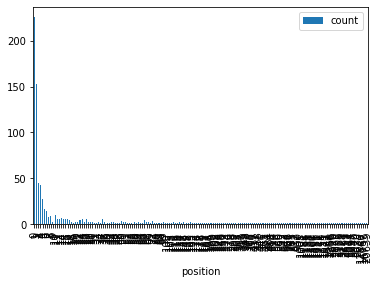

In [168]:
count_dict = {}
for (key,value) in final_antonym_dict.items():
    
    for temp_num in range(2):
        no_predict = 0

        print("==========================================================")
        text = templates[temp_num].replace('*',key)
        print(text)

        # module
        if mask_token is not None:
            text = text.replace(' _ ', ' %s ' % mask_token)
        tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(text, add_special_tokens=True))
        tokens = ['*' if token in ['*', 'Ġ*'] else token for token in tokens]
        marker = '*'
        if marker in tokens:
            assert tokens.count(marker) == 2, str(tokens)
            p, h = [i for i, token in enumerate(tokens) if token == marker]
            tokens = [token for token in tokens if token != marker]
            h -= 1
            print(tokens[p], tokens[h])
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        pred_idx = [i for i, token in enumerate(tokens) if token == mask_token] if mask_token is not None else [-1]
        tokens = ['@' + token if not token.startswith('Ġ') and token not in ['<s>', '</s>', '<mask>'] else token.replace('Ġ', '') 
                  for token in tokens] 
        #print(tokens)

        input_ids = torch.tensor([token_ids])
        with torch.no_grad():
            logits, attns = model(input_ids, output_attentions=True)
            probs = F.softmax(logits, dim=-1)

        for i in pred_idx:
            top_probs, top_indexes = probs[0][i].topk(10)
            top_tokens = tokenizer.convert_ids_to_tokens(top_indexes) 


            # remove G
            ans = []
            for word in top_tokens:
                ans.append(word[1:])
            print(ans)
            print(top_probs)


            # 找到每个同义词位于预测的第几个位置，先找到概率最大的，再去找最大的是预测的第几个
            # 找到每个同义词对应的概率
            word_probe = {}
            for word in value:
                word_id = tokenizer._convert_token_to_id('Ġ'+ word)
                if (word_id != 3):
                    word_probe[word] = probs[0][i][word_id]
                else:
                    print(word + 'is not in list')

            print(word_probe)

            # 找到同义词中概率最大的词和值

            # 没有反义词在预测的结果里
            # 保存计算结果的json文件中写为 -1
            if (len(word_probe)==0):
                no_predict = 1
                break


            max_word = max(word_probe, key=word_probe.get)
            max_probe = word_probe[max_word]

            print('max_probe is: ',end='')
            print(max_probe)

            # 判断概率最大的同义词是预测的第几个
            # 不要陷入死循环
            # k的值不要超过 tensor 的长度
            k = 10
            probe_get = 0
            while(probe_get == 0):
                top_probs, top_indexes = probs[0][i].topk(k)
                #print(top_probs)
                if max_probe in top_probs:
                    print('the position of max probe is: ',end='')
                    print((top_probs == max_probe).nonzero().item())
                    print('-----------------------------------------------------')

                    probe_get = 1
                else:
                    k=k*2
                    print(k)
                    if (k >= list(probs[0][i].size())[0]):
                        top_probs, top_indexes = probs[0][i].topk(probs[0][i].size())
                        print(top_probs)
                        print('the position of max probe is: ',end='')
                        print((top_probs == max_probe).nonzero().item())
                        print('-----------------------------------------------------')
                        probe_get = 1


            print('*****************************************************')

        # 没有预测结果
        if(no_predict == 1):
            # 写入结果文件
            if (temp_num == 0):
                result_dict[key] = [result_dict[key],-1]
            else:
                result_dict[key].append(-1)
            break

        # 有预测结果
        position = (top_probs == max_probe).nonzero().item()

        # 写入结果文件
        if (temp_num == 0):
            result_dict[key] = [result_dict[key],position]
        else:
            result_dict[key].append(position)


        if position not in count_dict:
            count_dict[position] = 1
        else:
            count_dict[position]+=1

            
# 保存到json文件
with open("sample.json", "w") as outfile:  
    json.dump(result_dict, outfile)
            
# 画图

count_dict_keys = count_dict.keys()
count_dict_values = count_dict.values()

data = {
    'count':Series(count_dict_values),
    'position':Series(count_dict_keys)
}

df = DataFrame(data)
df.sort_values("position",inplace=True)
print(df)
# plt.bar(count_dict_keys,count_dict_values)
df.plot(x='position',y='count',kind='bar')

In [169]:
# 分析结束，结果文件: antonym_result.json